# paftdunk

Let's create some fake data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.datasets import make_blobs

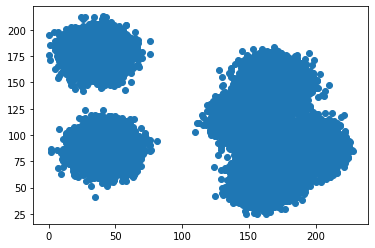

In [31]:
X, y = make_blobs(n_samples = 50000, centers=6)
X = np.round(X*10)
X += np.abs(np.min(X))
plt.scatter(X[:, 0], X[:, 1])

Possible hyperparams; 

- min overlap rows
- min user occurence
- min item occurence


In [79]:
min_overlap = 5
min_item_occ = 5
min_user_occ = 5

def window(seq):
    for idx in range(len(seq) - 1):
        yield seq[idx], seq[idx+1]
        yield seq[idx + 1], seq[idx]

def start_pipeline(dataf):
    return dataf.copy()

def remove_outliers(dataf, min_items_per_user=0, min_users_per_item=0):
    user_df = calc_user_activity(dataf)
    item_df = calc_item_activity(dataf)
    bad_users = user_df.loc[lambda d: d['n_uniq_item'] < min_items_per_user].user_id
    bad_items = item_df.loc[lambda d: d['n_uniq_user'] < min_users_per_item].item_id
    return (dataf
             .loc[lambda d: ~d['user_id'].isin(bad_users)]
             .loc[lambda d: ~d['item_id'].isin(bad_items)])

def calc_overlap_df(dataf):
    agg_df = dataf.groupby('user_id').apply(lambda d: list(d['item_id']))
    chain_of_window = chain(*(list(window(i[1])) for i in agg_df.items()))
    return (pd.DataFrame(chain_of_window, columns=['item_from', 'item_id'])
              .assign(n=1)
              .groupby(['item_from', 'item_id'])
              .agg(n_overlap=('n', 'count'))
              .reset_index())

def calc_itemitem(dataf):
    item_df = calc_item_activity(dataf)
    return (dataf 
             .pipe(calc_overlap_df)
             .set_index('item_id')
             .join(item_df.set_index('item_id'))
             .reset_index()
             .assign(p=lambda d: d['n_overlap']/d['n_uniq_user'])
             .sort_values(['item_from', 'p'], ascending=[True, False]))

def calc_user_activity(dataf):
    return (dataf
               .groupby('user_id')
               .agg(n_uniq_item=('item_id', 'nunique'))
               .reset_index())

def calc_item_activity(dataf):
    return (dataf
               .groupby('item_id')
               .agg(n_uniq_user=('user_id', 'nunique'))
               .reset_index())

In [80]:
df = pd.DataFrame(X, columns=['user_id', 'item_id']).astype(int)
(df
 .pipe(remove_outliers, min_items_per_user=5, min_users_per_item=5)
 .pipe(calc_itemitem))

,item_id,item_from,n_overlap,n_uniq_user,p
188,38,30,1,23,0.043478
15124,150,30,2,58,0.034483
12681,131,30,1,49,0.020408
14704,147,30,1,51,0.019608
2126,56,30,1,53,0.018868
...,...,...,...,...,...
18488,173,207,1,61,0.016393
18606,174,207,1,65,0.015385
9608,106,207,1,104,0.009615
7349,91,207,1,107,0.009346


In [33]:
from collections import Counter

agg_df = df.groupby('user_id').apply(lambda d: list(d['item_id']))

In [44]:
from itertools import islice, chain

def window(seq):
    for idx in range(len(seq) - 1):
        yield seq[idx], seq[idx+1]
        yield seq[idx + 1], seq[idx]

In [59]:
item_df = (df
           .assign(value=1)
           .groupby('item_id')
           .agg(n_single=('user_id', 'nunique'))
           .reset_index())

In [62]:
itemitem_df = pd.DataFrame(chain(*(list(window(i[1])) for i in agg_df.items())), columns=['item_from', 'item_id'])
agg_itemitem = (itemitem_df
                .assign(n=1)
                .groupby(['item_from', 'item_id'])
                .agg(n_overlap=('n', 'count'))
                .reset_index())

In [67]:
(agg_itemitem
 .set_index('item_id')
 .join(item_df.set_index('item_id'))
 .reset_index()
 .assign(p=lambda d: d['n_overlap']/d['n_single'])
 .sort_values(['item_from', 'p'], ascending=[True, False]))

,item_id,item_from,n_overlap,n_single,p
271,39,25,1,32,0.031250
14345,144,25,1,45,0.022222
12044,125,25,1,46,0.021739
11795,123,25,1,58,0.017241
16184,157,25,1,72,0.013889
...,...,...,...,...,...
17514,165,212,1,78,0.012821
16640,159,212,1,79,0.012658
8132,96,212,1,120,0.008333
18309,171,213,1,72,0.013889


In [ ]:
df.reset_index()